In [2]:
import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
import numpy as np
from astropy.stats import sigma_clip, sigma_clipped_stats
from scipy.stats import sigmaclip

import lsst.afw.math as afwMath
import lsst.pex.config as pexConfig
import lsst.pipe.base as pipeBase
from lsst.cp.pipe.utils import (arrangeFlatsByExpTime, arrangeFlatsByExpId,
                                sigmaClipCorrection, CovFastFourierTransform)

import lsst.pipe.base.connectionTypes as cT

from lsst.ip.isr import PhotonTransferCurveDataset
from lsst.ip.isr import IsrTask

# Loading collection

In [3]:
genCollection = "u/lgiraldo/bps_ALLCCD_20220701"
butler = dB.Butler("/repo/main/", collections=genCollection)

# CCD Identifiers

In [4]:
camera = butler.get("camera", instrument="LSSTCam")

det_name_to_id = {}  ##From name to number
det_id_to_name = {}  ##From number to name
det_name_array = []  ##List with names

for det in camera:
    #print(det.getName(), det.getId())
    detName, detId = det.getName(), det.getId()
    if detId < 189:
        det_name_to_id[detName] = detId
        det_id_to_name[detId] = detName
        det_name_array.append(detName)

# Camera, detector and amplifier as objects

In [5]:
CCD=55
camera = butler.get("camera", instrument="LSSTCam")  ## Camera object
for det in camera:
    if det.getId() == CCD:
        detector = det  ##Detector object
        
amp_object = {}
ampNames = []  ##Amplifier names

for amp in detector:
    amp_object[amp.getName()] = amp.getBBox()  ## Amplifier location
    ampNames += [amp.getName()]
    
amp_object

{'C10': Box2I(corner=Point2I(0, 2002), dimensions=Extent2I(512, 2002)),
 'C11': Box2I(corner=Point2I(512, 2002), dimensions=Extent2I(512, 2002)),
 'C12': Box2I(corner=Point2I(1024, 2002), dimensions=Extent2I(512, 2002)),
 'C13': Box2I(corner=Point2I(1536, 2002), dimensions=Extent2I(512, 2002)),
 'C14': Box2I(corner=Point2I(2048, 2002), dimensions=Extent2I(512, 2002)),
 'C15': Box2I(corner=Point2I(2560, 2002), dimensions=Extent2I(512, 2002)),
 'C16': Box2I(corner=Point2I(3072, 2002), dimensions=Extent2I(512, 2002)),
 'C17': Box2I(corner=Point2I(3584, 2002), dimensions=Extent2I(512, 2002)),
 'C07': Box2I(corner=Point2I(3584, 0), dimensions=Extent2I(512, 2002)),
 'C06': Box2I(corner=Point2I(3072, 0), dimensions=Extent2I(512, 2002)),
 'C05': Box2I(corner=Point2I(2560, 0), dimensions=Extent2I(512, 2002)),
 'C04': Box2I(corner=Point2I(2048, 0), dimensions=Extent2I(512, 2002)),
 'C03': Box2I(corner=Point2I(1536, 0), dimensions=Extent2I(512, 2002)),
 'C02': Box2I(corner=Point2I(1024, 0), dimen

# Read-out noise

This code was extracted from cp_pipe, the LSST repository https://github.com/lsst/cp_pipe/blob/main/python/lsst/cp/pipe/ptc/cpExtractPtcTask.py#L771

In [6]:
def getReadNoiseFromMetadata(taskMetadata, ampName):
    """Gets readout noise for an amp from ISR metadata.
    Parameters
    ----------
    taskMetadata : `list` [`lsst.pipe.base.TaskMetadata`]
                List of exposures metadata from ISR.
    ampName : `str`
        Amplifier name.
    Returns
    -------
    readNoise : `float`
        Median of the overscan readnoise in the
        post-ISR metadata of the input exposures (ADU).
        Returns 'None' if the median could not be calculated.
    """
    # Empirical readout noise [ADU] measured from an
    # overscan-subtracted overscan during ISR.
    expectedKey = f"RESIDUAL STDEV {ampName}"

    readNoises = []
    for meta in taskMetadata:
        for expMetadata in meta:
            if 'isr' in expMetadata:
                overscanNoise = meta['isr'][expectedKey]
            else:
                continue
            readNoises.append(overscanNoise)

    if len(readNoises):
        readNoise = np.median(np.array(readNoises))
    else:
        print("Median readout noise from ISR metadata for amp %s "
                         "could not be calculated." % ampName)
        readNoise = None
    
    return readNoise

# Exposures

In [7]:
##List of exposures for the run 13144
exposure_pairs = np.load('./Data_files/exposure_pairs.txt.npy')

##Exposures with Flux ~ 5000 ADU
exp_index = np.where(exposure_pairs == [3021120700503, 3021120700504])[0][0]

##Images already reduced for the above exposures
##cpPtcProc contains reduced images for all exposures used in the collection loaded, 
#which also contains PTC and cpCovariances objects
exp1 = butler.get('cpPtcProc', detector=CCD, exposure=exposure_pairs[exp_index, 0], instrument='LSSTCam')
exp2 = butler.get('cpPtcProc', detector=CCD, exposure=exposure_pairs[exp_index, 1], instrument='LSSTCam')

##Initializing dictionary to save noise from medatada
readNoiseDict = {ampName: [] for ampName in ampNames}

metadata1 = butler.get('isr_metadata', detector=CCD, instrument='LSSTCam', exposure=exposure_pairs[exp_index, 0])
metadata2 = butler.get('isr_metadata', detector=CCD, instrument='LSSTCam', exposure=exposure_pairs[exp_index, 1])

##Saving metadata for pair of flats
metadata = [metadata1, metadata2]

for ampName in ampNames:
    # Overscan readnoise from post-ISR exposure metadata.
    # It will be used to estimate the gain from a pair of flats.
    readNoiseDict[ampName].append(getReadNoiseFromMetadata(metadata, ampName))
readNoiseDict

{'C10': [3.603849701748253],
 'C11': [3.578682818253572],
 'C12': [3.589762850275914],
 'C13': [3.6181512974790953],
 'C14': [3.7682542438163846],
 'C15': [3.5470712478194253],
 'C16': [3.5327636833256095],
 'C17': [3.6796256741292526],
 'C07': [3.7125723471204037],
 'C06': [3.727220970059814],
 'C05': [3.547040778016429],
 'C04': [3.495840711411364],
 'C03': [3.4996398778511297],
 'C02': [3.4818950513058287],
 'C01': [3.503855619720707],
 'C00': [3.4635965249370786]}

https://github.com/lsst/cp_pipe/blob/15549172f4a5f84743228b263cf0f3707bc7ebf7/python/lsst/cp/pipe/ptc/cpExtractPtcTask.py#L660-L746

In [8]:
def getGainFromFlatPair_noMask(exposure1, exposure2, correctionType='NONE',
                            readNoise=None, region=None, clip=True):
    """Estimate the gain from a single pair of flats.
    The basic premise is 1/g = <(I1 - I2)^2/(I1 + I2)>,
    where I1 and I2 correspond to flats 1 and 2, respectively.
    Corrections for the variable QE and the read-noise are then made
    following the derivation in Robert Lupton's forthcoming book,
    which gets
    1/g = <(I1 - I2)^2/(I1 + I2)> - 1/mu(sigma^2 - 1/2g^2)
    See below for the full solution.
    https://www.wolframalpha.com/input/?i=solve+1%2Fy+%3D+c+-+(1%2Fm)*(s^2+-+1%2F(2y^2))+for+y
    where mu is the average signal level, and sigma is the
    amplifier's readnoise. The way the correction is applied depends on
    the value supplied for correctionType.
    correctionType is one of ['NONE', 'SIMPLE' or 'FULL']
        'NONE' : uses the 1/g = <(I1 - I2)^2/(I1 + I2)> formula
        'SIMPLE' : uses the gain from the 'NONE' method for the 1/2g^2 term
        'FULL'   : solves the full equation for g, discarding the
                   non-physical solution to the resulting quadratic.
    Parameters
    ----------
    exposure1 : `lsst.afw.image.exposure.ExposureF`
        First exposure of flat field pair.
    exposure2 : `lsst.afw.image.exposure.ExposureF`
        Second exposure of flat field pair.
    correctionType : `str`, optional
        The correction applied, one of ['NONE', 'SIMPLE', 'FULL']
    readnoise : `float`, optional
        Amplifier readout noise.
    region : `lsst.geom.Box2I`, optional
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    Returns
    -------
    gain : `float`
        Gain, in e/ADU.
    Raises
    ------
        RuntimeError: if `correctionType` is not one of 'NONE',
            'SIMPLE', or 'FULL'.
        RuntimeError: if a readout noise value is not provided
            when `correctionType` is different from 'NONE'.
    """
    if correctionType not in ['NONE', 'SIMPLE', 'FULL']:
        raise RuntimeError("Unknown correction type %s" % correctionType)

    if correctionType != 'NONE' and readNoise is None:
        raise RuntimeError("Must supply a readout noise value if "
                           "performing gain correction.")

    if region is not None:
        im1Area = exposure1.getImage()[region].getArray()
        im2Area = exposure2.getImage()[region].getArray()
    else:
        im1Area = exposure1.getImage().getArray()
        im2Area = exposure2.getImage().getArray()

    #const = np.mean((im1Area - im2Area)**2 / (im1Area + im2Area))
    #gain = 1. / const
    #print(gain)
    #mu = 0.5*(np.mean(im1Area) + np.mean(im2Area))
    
    ratioIm = (im1Area - im2Area)**2 / (im1Area + im2Area)
    
    
    if clip == True:
        ## "sigma_clipped_stats" returns mean, median, and stddev
        
        stats1_clip = sigma_clipped_stats(im1Area, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc, cenfunc='median', stdfunc='std')
        stats2_clip = sigma_clipped_stats(im2Area, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc, cenfunc='median', stdfunc='std')
        mu1= stats1_clip[0]
        mu2= stats2_clip[0]
        mu = 0.5 * (mu1 + mu2) / 2.0
        
        stats_ratioIm = sigma_clipped_stats(ratioIm, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc, cenfunc='median', stdfunc='std')
        const = stats_ratioIm[0]
    else:
        mu = 0.5*(np.mean(im1Area) + np.mean(im2Area))
        const = np.mean(ratioIm)
    
    gain = 1. / const

    if correctionType == 'SIMPLE':
        gain = 1/(const - (1/mu)*(readNoise**2 - (1/2*gain**2)))
    elif correctionType == 'FULL':
        root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
        denom = (2*const*mu - 2*readNoise**2)

        positiveSolution = (root + mu)/denom
        negativeSolution = (mu - root)/denom  # noqa: F841 unused, but the other solution

        gain = positiveSolution

    return gain

In [9]:
def getGainFromFlatPair_Mask(exposure1, exposure2, correctionType='NONE',
                            readNoise=None, region=None, clip = False):
    """Estimate the gain from a single pair of flats.
    The basic premise is 1/g = <(I1 - I2)^2/(I1 + I2)>,
    where I1 and I2 correspond to flats 1 and 2, respectively.
    Corrections for the variable QE and the read-noise are then made
    following the derivation in Robert Lupton's forthcoming book,
    which gets
    1/g = <(I1 - I2)^2/(I1 + I2)> - 1/mu(sigma^2 - 1/2g^2)
    See below for the full solution.
    https://www.wolframalpha.com/input/?i=solve+1%2Fy+%3D+c+-+(1%2Fm)*(s^2+-+1%2F(2y^2))+for+y
    where mu is the average signal level, and sigma is the
    amplifier's readnoise. The way the correction is applied depends on
    the value supplied for correctionType.
    correctionType is one of ['NONE', 'SIMPLE' or 'FULL']
        'NONE' : uses the 1/g = <(I1 - I2)^2/(I1 + I2)> formula
        'SIMPLE' : uses the gain from the 'NONE' method for the 1/2g^2 term
        'FULL'   : solves the full equation for g, discarding the
                   non-physical solution to the resulting quadratic.
    Parameters
    ----------
    exposure1 : `lsst.afw.image.exposure.ExposureF`
        First exposure of flat field pair.
    exposure2 : `lsst.afw.image.exposure.ExposureF`
        Second exposure of flat field pair.
    correctionType : `str`, optional
        The correction applied, one of ['NONE', 'SIMPLE', 'FULL']
    readnoise : `float`, optional
        Amplifier readout noise.
    region : `lsst.geom.Box2I`, optional
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    Returns
    -------
    gain : `float`
        Gain, in e/ADU.
    Raises
    ------
        RuntimeError: if `correctionType` is not one of 'NONE',
            'SIMPLE', or 'FULL'.
        RuntimeError: if a readout noise value is not provided
            when `correctionType` is different from 'NONE'.
    """
    if correctionType not in ['NONE', 'SIMPLE', 'FULL']:
        raise RuntimeError("Unknown correction type %s" % correctionType)

    if correctionType != 'NONE' and readNoise is None:
        raise RuntimeError("Must supply a readout noise value if "
                           "performing gain correction.")

    if region is not None:
        im1Area = exposure1.maskedImage[region]
        im2Area = exposure2.maskedImage[region]
    else:
        im1Area = exposure1.maskedImage
        im2Area = exposure2.maskedImage
    
    im1AreaC = im1Area.clone()
    im2AreaC = im2Area.clone()
    
    ##Creating the union of the masks of each of the images
    umask = np.logical_or(im1AreaC.mask.array, im2AreaC.mask.array)
    
    ##Applying the "umask" to each image
    im1_mask = np.ma.masked_where(umask, im1AreaC.image.array)
    im2_mask = np.ma.masked_where(umask, im2AreaC.image.array)
    
    diffIm = (im1_mask - im2_mask)**2
    
    # Sum of pairs
    sumIm = im1_mask + im2_mask
    ratioIm = diffIm / sumIm
    
    if clip == True:
        ## "sigma_clipped_stats" returns mean, median, and stddev
        
        stats1_clip = sigma_clipped_stats(im1_mask, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc, cenfunc='median', stdfunc='std')
        stats2_clip = sigma_clipped_stats(im2_mask, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc, cenfunc='median', stdfunc='std')
        mu1= stats1_clip[0]
        mu2= stats2_clip[0]
        mu = 0.5 * (mu1 + mu2) / 2.0
        
        stats_ratioIm = sigma_clipped_stats(ratioIm, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc, cenfunc='median', stdfunc='std')
        const = stats_ratioIm[0]
    else:
        mu = 0.5*(np.mean(im1_mask) + np.mean(im2_mask))
        const = np.mean(ratioIm)
    
    gain = 1. / const

    if correctionType == 'SIMPLE':
        gain = 1/(const - (1/mu)*(readNoise**2 - (1/2*gain**2)))
    elif correctionType == 'FULL':
        root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
        denom = (2*const*mu - 2*readNoise**2)

        positiveSolution = (root + mu)/denom
        negativeSolution = (mu - root)/denom  # noqa: F841 unused, but the other solution

        gain = positiveSolution

    return gain

# Configuration

In [10]:
##Config
binSize = 1
maskNameList=['SUSPECT', 'BAD', 'NO_DATA', 'SAT']
nSigmaClipPtc = 5.5
nIterSigmaClipPtc = 3

# PTC Gain

In [11]:
ccd_data= butler.get("ptc", instrument="LSSTCam", detector=CCD)
ptc_gain = ccd_data.gain

In [12]:
def mask_nomask_func(amp, corr_type, region_obj, clip = True):
    """
    This function calculates the gain using a pair of flats with and without mask in the image.
    
    Parameters
    ----------
    amp: str with amplifier name, e.g. 'C00'
    corr_type: str, one of ['NONE', 'SIMPLE', 'FULL']
    region_obj: `lsst.geom.Box2I`
        Region of each exposure where to perform the calculations
        (e.g, an amplifier).
    
    Returns
    -------
    gain_nomask: float, gain calculated without mask
    gain_mask: float, gain calculated with mask
    rel_nomask: float, relative percentage error between gain from 'gain_nomask' and PTC gain
    rel_mask: float, relative percentage error between gain from 'gain_mask' and PTC gain
    """
    
    #mask1, stat_c, mu1= getImageAreasMasksStats(exp1, region=region_obj)
    
    if corr_type == 'NONE':
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType='NONE',
                                readNoise=None, region=region_obj, clip=clip)
        gain_mask = getGainFromFlatPair_Mask(exp1, exp2, correctionType='NONE', 
                                               readNoise=None, region=region_obj, clip = clip)
    else:
        gain_nomask = getGainFromFlatPair_noMask(exp1, exp2, correctionType=corr_type,
                            readNoise=readNoiseDict[amp][0], region=region_obj, clip=clip)
        gain_mask = getGainFromFlatPair_Mask(exp1, exp2, correctionType=corr_type, 
                                           readNoise=readNoiseDict[amp][0], region=region_obj, 
                                             clip = clip)
    rel_nomask = abs(gain_nomask- ptc_gain[amp])/ptc_gain[amp]*100
    rel_mask = abs(gain_mask - ptc_gain[amp])/ptc_gain[amp]*100
        
    return gain_nomask, gain_mask, rel_nomask, rel_mask

In [13]:
none = [] #gain_nomask, gain_mask, rel_nomask, rel_mask
simple = []
full = []
for amp in ampNames:
    none += [mask_nomask_func(amp, 'NONE', amp_object[amp])]
    simple += [mask_nomask_func(amp, 'SIMPLE', amp_object[amp])]
    full += [mask_nomask_func(amp, 'FULL', amp_object[amp])]
    
none = np.array(none)
simple = np.array(simple)
full = np.array(full)

# Plots

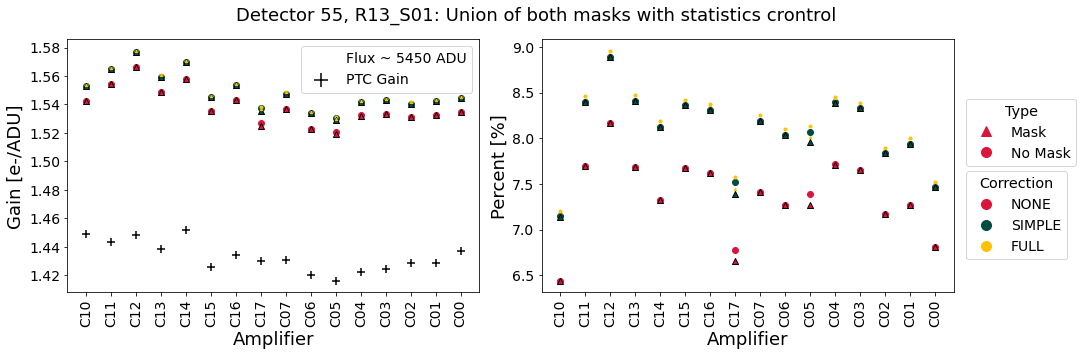

In [41]:
fig,axes = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(f'Detector {CCD}, {det_id_to_name[CCD]}: Union of both masks with statistics crontrol',
            fontsize = 18)
axes[0].scatter(ampNames, none[:,0], c= 'crimson')
axes[0].scatter(ampNames, simple[:,0], c= '#004D40')
axes[0].scatter(ampNames, full[:,0], c= '#FFC107', marker = '.')

axes[0].scatter(ampNames, none[:,1], c= 'crimson', marker = '^', edgecolor = 'black')
axes[0].scatter(ampNames, simple[:,1], c= '#004D40',marker = '^', edgecolor = 'black')
axes[0].scatter(ampNames, full[:,1], c= '#FFC107', marker = '^', s = 5)

axes[0].plot([], [], '.', label='Flux ~ 5450 ADU', ms = 0.5, color='white');
axes[0].scatter(ptc_gain.keys(), ptc_gain.values(), c='black', marker= '+', label='PTC Gain', s=50);

axes[1].scatter(ampNames, none[:,2], c= 'crimson')
axes[1].scatter(ampNames, simple[:,2], c= '#004D40')
axes[1].scatter(ampNames, full[:,2], c= '#FFC107', marker = '.')

axes[1].scatter(ampNames, none[:,3], c= 'crimson', marker = '^', edgecolor = 'black')
axes[1].scatter(ampNames, simple[:,3], c= '#004D40', marker = '^', edgecolor = 'black')
axes[1].scatter(ampNames, full[:,3], c= '#FFC107', marker = '^', s = 5)

for i in range(2):
    axes[i].set_xlabel('Amplifier', fontsize = 18)
axes[0].set_ylabel('Gain [e-/ADU]', fontsize = 18)
axes[1].set_ylabel('Percent [%]', fontsize = 18)

axes[0].legend(loc='best', fontsize = 14, markerscale=2)
for i in range(2):    
    axes[i].tick_params(axis='x', labelsize=14, labelrotation=90)
    axes[i].tick_params(axis='y', labelsize=14)

t = plt.plot([],[], color="crimson", marker="^", ms=10, ls="")[0]
c = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
lg1 = plt.legend(handles=[t,c], labels=['Mask','No Mask'],loc=(1.03,0.5), title="Type", fontsize = 14)
axes[1].add_artist(lg1)
n = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
s = plt.plot([],[], color='#004D40', marker="o", ms=10, ls="")[0]
f = plt.plot([],[], color='#FFC107', marker="o", ms=10, ls="")[0]

plt.legend(handles=[n,s,f], labels=['NONE','SIMPLE', 'FULL'],loc=(1.03,0.13), title="Correction", fontsize = 14);
plt.rcParams['legend.title_fontsize'] = 'x-large'
plt.tight_layout()
plt.savefig(f'./FocalPlane_plots/GainFlats_stats_det{CCD}.png')

In [31]:
NoClip_none = [] #gain_nomask, gain_mask, rel_nomask, rel_mask
NoClip_simple = []
NoClip_full = []
for amp in ampNames:
    NoClip_none += [mask_nomask_func(amp, 'NONE', amp_object[amp], clip = False)]
    NoClip_simple += [mask_nomask_func(amp, 'SIMPLE', amp_object[amp], clip = False)]
    NoClip_full += [mask_nomask_func(amp, 'FULL', amp_object[amp], clip = False)]
    
NoClip_none = np.array(NoClip_none)
NoClip_simple = np.array(NoClip_simple)
NoClip_full = np.array(NoClip_full)

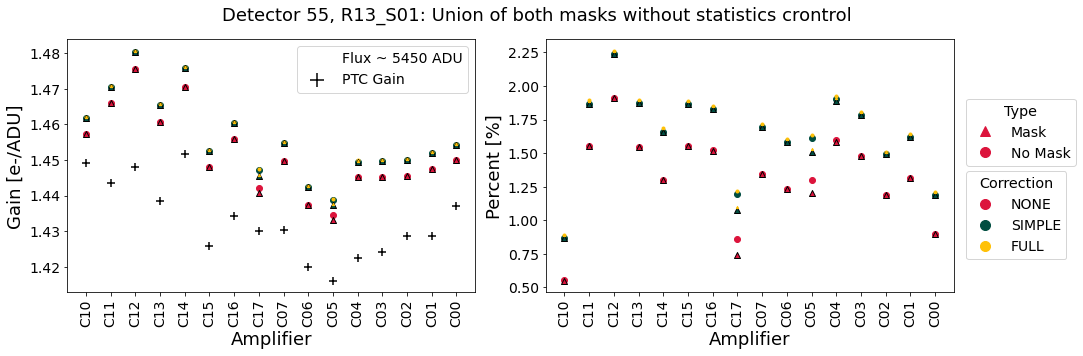

In [40]:
fig,axes = plt.subplots(1,2, figsize= (15,5))
fig.suptitle(f'Detector {CCD}, {det_id_to_name[CCD]}: Union of both masks without statistics crontrol',
            fontsize = 18)
axes[0].scatter(ampNames, NoClip_none[:,0], c= 'crimson')
axes[0].scatter(ampNames, NoClip_simple[:,0], c= '#004D40')
axes[0].scatter(ampNames, NoClip_full[:,0], c= '#FFC107', marker = '.')

axes[0].scatter(ampNames, NoClip_none[:,1], c= 'crimson', marker = '^', edgecolor = 'black')
axes[0].scatter(ampNames, NoClip_simple[:,1], c= '#004D40',marker = '^', edgecolor = 'black')
axes[0].scatter(ampNames, NoClip_full[:,1], c= '#FFC107', marker = '^', s = 5)

axes[0].plot([], [], '.', label='Flux ~ 5450 ADU', ms = 0.5, color='white');
axes[0].scatter(ptc_gain.keys(), ptc_gain.values(), c='black', marker= '+', label='PTC Gain', s = 50);

axes[1].scatter(ampNames, NoClip_none[:,2], c= 'crimson')
axes[1].scatter(ampNames, NoClip_simple[:,2], c= '#004D40')
axes[1].scatter(ampNames, NoClip_full[:,2], c= '#FFC107', marker = '.')

axes[1].scatter(ampNames, NoClip_none[:,3], c= 'crimson', marker = '^', edgecolor = 'black')
axes[1].scatter(ampNames, NoClip_simple[:,3], c= '#004D40', marker = '^', edgecolor = 'black')
axes[1].scatter(ampNames, NoClip_full[:,3], c= '#FFC107', marker = '^', s = 5)

for i in range(2):
    axes[i].set_xlabel('Amplifier', fontsize = 18)
axes[0].set_ylabel('Gain [e-/ADU]', fontsize = 18)
axes[1].set_ylabel('Percent [%]', fontsize = 18)

axes[0].legend(loc='best', fontsize = 14, markerscale=2)
for i in range(2):    
    axes[i].tick_params(axis='x', labelsize=14, labelrotation=90)
    axes[i].tick_params(axis='y', labelsize=14)

t = plt.plot([],[], color="crimson", marker="^", ms=10, ls="")[0]
c = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
lg1 = plt.legend(handles=[t,c], labels=['Mask','No Mask'],loc=(1.03,0.5), title="Type", fontsize = 14)
axes[1].add_artist(lg1)
n = plt.plot([],[], color="crimson", marker="o", ms=10, ls="")[0]
s = plt.plot([],[], color='#004D40', marker="o", ms=10, ls="")[0]
f = plt.plot([],[], color='#FFC107', marker="o", ms=10, ls="")[0]
plt.legend(handles=[n,s,f], labels=['NONE','SIMPLE', 'FULL'],loc=(1.03,0.13), title="Correction", fontsize = 14);
plt.rcParams['legend.title_fontsize'] = 'x-large'
plt.tight_layout()
plt.savefig(f'./FocalPlane_plots/GainFlats_NOstats_det{CCD}.png')

# Simulation

Modified from https://github.com/craiglagegit/ScratchStuff/blob/master/reca/Two_Flats_23Jul22.ipynb

In [165]:
##The shape of one LSSTCam amplifier
np.shape(im1Area.image.array)

(2002, 512)

## No mask

readNoise = 2.0 , correctionType = NONE, gain = 1.9994356212600606
readNoise = 2.0 , correctionType = SIMPLE, gain = 2.001036885320586
readNoise = 2.0 , correctionType = FULL, gain = 2.0025389017544684
readNoise = 10.0 , correctionType = NONE, gain = 1.9193583022334757
readNoise = 10.0 , correctionType = SIMPLE, gain = 1.9945115273110332
readNoise = 10.0 , correctionType = FULL, gain = 1.9958780952432822
readNoise = 20.0 , correctionType = NONE, gain = 1.7233300331734
readNoise = 20.0 , correctionType = SIMPLE, gain = 1.9977264643363772
readNoise = 20.0 , correctionType = FULL, gain = 1.9988124083059557


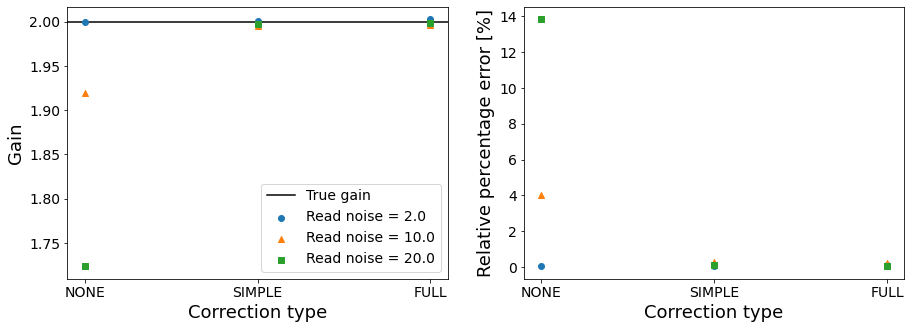

In [44]:
gain = 2.0     ##Reral gain
level = 10000  ##Expected value for Poisson distribution
sizex = 2002   ##Size in x for real amplifier
sizey = 512    ##Size in y for real amplifier

##Dictionary to save gain for different noise values
gain_val = {f'{readNoise}': [] for readNoise in [2.0, 10.0, 20.0]}

for readNoise in [2.0, 10.0, 20.0]:
    f1 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f2 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f1Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f1 += f1Noise
    
    f2Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f2 += f2Noise
    
    const = np.mean((f1- f2) * (f1 - f2) / (f1 + f2))
    mu = (np.mean(f1) + np.mean(f2)) / 2.0
    for correctionType in ['NONE', 'SIMPLE', 'FULL']:
        gainLupton = 1. / const
        if correctionType == 'SIMPLE':
            gainLupton = 1/(const - (1/mu)*(readNoise**2 - (1/2*gainLupton**2)))
        elif correctionType == 'FULL':
            root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
            denom = (2*const*mu - 2*readNoise**2)
            positiveSolution = (root + mu)/denom
            gainLupton = positiveSolution
        gain_val[f'{readNoise}'].append(gainLupton)
        print(f"readNoise = {readNoise} , correctionType = {correctionType}, gain = {gainLupton}")
        
fig, axes = plt.subplots(1,2, figsize= (15,5))
axes[0].axhline(gain, c='black', zorder=1, label = 'True gain')
axes[0].scatter(['NONE', 'SIMPLE', 'FULL'], gain_val['2.0'], zorder=2, label = 'Read noise = 2.0')
axes[0].scatter(['NONE', 'SIMPLE', 'FULL'], gain_val['10.0'], marker = '^', zorder=3, label = 'Read noise = 10.0')
axes[0].scatter(['NONE', 'SIMPLE', 'FULL'], gain_val['20.0'], marker = 's', zorder=4, label = 'Read noise = 20.0')

axes[1].scatter(['NONE', 'SIMPLE', 'FULL'], abs(np.array(gain_val['2.0']) - gain)/gain*100)
axes[1].scatter(['NONE', 'SIMPLE', 'FULL'], abs(np.array(gain_val['10.0']) - gain)/gain*100, marker = '^')
axes[1].scatter(['NONE', 'SIMPLE', 'FULL'], abs(np.array(gain_val['20.0']) - gain)/gain*100, marker = 's');
axes[0].legend(loc='best', fontsize=14)
for i in range(2):
    axes[i].set_xlabel('Correction type', fontsize = 18)
axes[0].set_ylabel('Gain', fontsize = 18)
for i in range(2):    
    axes[i].tick_params(labelsize=14)
axes[1].set_ylabel('Relative percentage error [%]', fontsize = 18);

## Añadiendo máscara

In [45]:
region = amp_object['C17']
im1Area = exp1.maskedImage[region]
im2Area = exp2.maskedImage[region]

im1AreaC = im1Area.clone()
im2AreaC = im2Area.clone()

##Union of both masks
umask = np.logical_or(im1AreaC.mask.array, im2AreaC.mask.array)
im1_mask = np.ma.masked_where(umask, f1) ##Applying mask to image 1

print(im1Area.mask.printMaskPlanes())
np.mean(f1), np.mean(im1_mask)

None
Plane 0 -> BAD
Plane 3 -> CR
Plane 5 -> DETECTED
Plane 6 -> DETECTED_NEGATIVE
Plane 4 -> EDGE
Plane 2 -> INTRP
Plane 8 -> NO_DATA
Plane 1 -> SAT
Plane 7 -> SUSPECT
Plane 9 -> UNMASKEDNAN


(5000.084238860967, 5000.083785747985)

readNoise = 2.0 , correctionType = NONE, gain = 1.9945989645280915
readNoise = 2.0 , correctionType = SIMPLE, gain = 1.9962001897798125
readNoise = 2.0 , correctionType = FULL, gain = 1.9976867619335257
readNoise = 10.0 , correctionType = NONE, gain = 1.9263004897205602
readNoise = 10.0 , correctionType = SIMPLE, gain = 2.0019980898869725
readNoise = 10.0 , correctionType = FULL, gain = 2.0033864035726
readNoise = 20.0 , correctionType = NONE, gain = 1.7267369124967236
readNoise = 20.0 , correctionType = SIMPLE, gain = 2.0023005370144507
readNoise = 20.0 , correctionType = FULL, gain = 2.0033966348055348


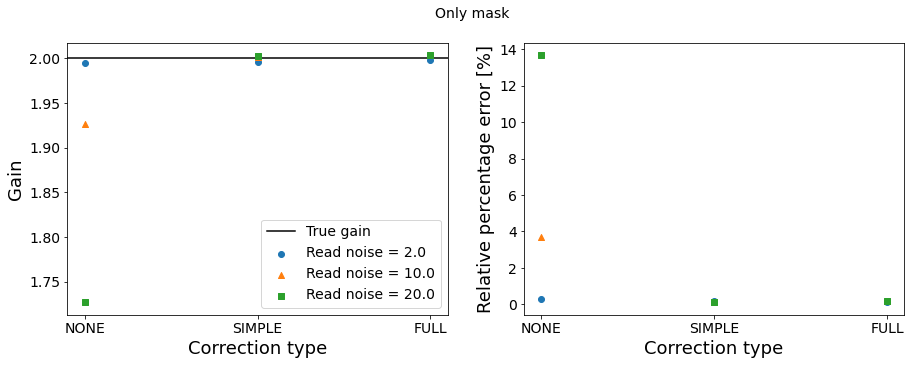

In [46]:
gain_val = {f'{readNoise}': [] for readNoise in [2.0, 10.0, 20.0]}

for readNoise in [2.0, 10.0, 20.0]:
    f1 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f2 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f1Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f1 += f1Noise
    f1_mask = np.ma.masked_where(umask, f1) ##Applying mask to image 1
    f2Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f2 += f2Noise
    f2_mask = np.ma.masked_where(umask, f2) ##Applying mask to image 1
    const = np.mean((f1_mask - f2_mask) * (f1_mask - f2_mask) / (f1_mask + f2_mask))
    mu = (np.mean(f1_mask) + np.mean(f2_mask)) / 2.0
    for correctionType in ['NONE', 'SIMPLE', 'FULL']:
        gainLupton = 1. / const
        if correctionType == 'SIMPLE':
            gainLupton = 1/(const - (1/mu)*(readNoise**2 - (1/2*gainLupton**2)))
        elif correctionType == 'FULL':
            root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
            denom = (2*const*mu - 2*readNoise**2)
            positiveSolution = (root + mu)/denom
            gainLupton = positiveSolution
        gain_val[f'{readNoise}'].append(gainLupton)
        print(f"readNoise = {readNoise} , correctionType = {correctionType}, gain = {gainLupton}")
        
fig, axes = plt.subplots(1,2, figsize= (15,5))
fig.suptitle('Only mask', fontsize = 14)
axes[0].axhline(gain, c='black', zorder=1, label = 'True gain')
axes[0].scatter(['NONE', 'SIMPLE', 'FULL'], gain_val['2.0'], zorder=2, label = 'Read noise = 2.0')
axes[0].scatter(['NONE', 'SIMPLE', 'FULL'], gain_val['10.0'], marker = '^', zorder=3, label = 'Read noise = 10.0')
axes[0].scatter(['NONE', 'SIMPLE', 'FULL'], gain_val['20.0'], marker = 's', zorder=4, label = 'Read noise = 20.0')

axes[1].scatter(['NONE', 'SIMPLE', 'FULL'], abs(np.array(gain_val['2.0']) - gain)/gain*100)
axes[1].scatter(['NONE', 'SIMPLE', 'FULL'], abs(np.array(gain_val['10.0']) - gain)/gain*100, marker = '^')
axes[1].scatter(['NONE', 'SIMPLE', 'FULL'], abs(np.array(gain_val['20.0']) - gain)/gain*100, marker = 's');
axes[0].legend(loc='best', fontsize=14)
for i in range(2):
    axes[i].set_xlabel('Correction type', fontsize = 18)
axes[0].set_ylabel('Gain', fontsize = 18)
for i in range(2):    
    axes[i].tick_params(labelsize=14)
axes[1].set_ylabel('Relative percentage error [%]', fontsize = 18);

## Adding statistics control

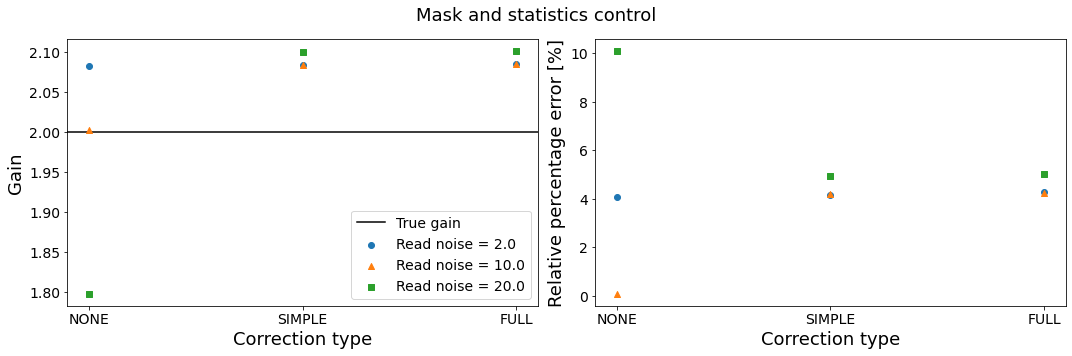

In [48]:
nSigmaClipPtc = 5.5
nIterSigmaClipPtc = 3
gain_val = {f'{readNoise}': [] for readNoise in [2.0, 10.0, 20.0]}

for readNoise in [2.0, 10.0, 20.0]:
    f1 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f2 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f1Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f1 += f1Noise
    f1_mask = np.ma.masked_where(umask, f1)
    f2Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f2 += f2Noise
    f2_mask = np.ma.masked_where(umask, f2)


    diffIm = (f1_mask - f2_mask)**2
    sumIm = f1_mask + f2_mask
    ratioIm = diffIm / sumIm

    stats1_clip = sigma_clipped_stats(f1_mask, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc, cenfunc='mean', stdfunc='std')
    stats2_clip = sigma_clipped_stats(f2_mask, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc, cenfunc='mean', stdfunc='std')
    mu1= stats1_clip[0]
    mu2= stats2_clip[0]
    mu = (mu1 + mu2) / 2.0

    stats_clip = sigma_clipped_stats(ratioIm, sigma=nSigmaClipPtc, maxiters=nIterSigmaClipPtc, cenfunc='mean', stdfunc='std')
    const = stats_clip[0]


    for correctionType in ['NONE', 'SIMPLE', 'FULL']:
        gainLupton = 1. / const
        if correctionType == 'SIMPLE':
            gainLupton = 1/(const - (1/mu)*(readNoise**2 - (1/2*gainLupton**2)))
        elif correctionType == 'FULL':
            root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
            denom = (2*const*mu - 2*readNoise**2)
            positiveSolution = (root + mu)/denom
            gainLupton = positiveSolution
        gain_val[f'{readNoise}'].append(gainLupton)
        #print(f"readNoise = {readNoise} , correctionType = {correctionType}, gain = {gainLupton}")

fig, axes = plt.subplots(1,2, figsize= (15,5))
fig.suptitle('Mask and statistics control', fontsize = 18)

axes[0].axhline(gain, c='black', zorder=1, label = 'True gain')
axes[0].scatter(['NONE', 'SIMPLE', 'FULL'], gain_val['2.0'], zorder=2, label = 'Read noise = 2.0')
axes[0].scatter(['NONE', 'SIMPLE', 'FULL'], gain_val['10.0'], marker = '^', zorder=3, label = 'Read noise = 10.0')
axes[0].scatter(['NONE', 'SIMPLE', 'FULL'], gain_val['20.0'], marker = 's', zorder=4, label = 'Read noise = 20.0')


axes[1].scatter(['NONE', 'SIMPLE', 'FULL'], abs(np.array(gain_val['2.0']) - gain)/gain*100)
axes[1].scatter(['NONE', 'SIMPLE', 'FULL'], abs(np.array(gain_val['10.0']) - gain)/gain*100, marker = '^')
axes[1].scatter(['NONE', 'SIMPLE', 'FULL'], abs(np.array(gain_val['20.0']) - gain)/gain*100, marker = 's');
axes[0].legend(loc='best', fontsize=14)
for i in range(2):
    axes[i].set_xlabel('Correction type', fontsize = 18)
axes[0].set_ylabel('Gain', fontsize = 18)
for i in range(2):    
    axes[i].tick_params(labelsize=14)
axes[1].set_ylabel('Relative percentage error [%]', fontsize = 18);
fig.tight_layout()
fig.savefig('./FocalPlane_plots/Simulation_masks_stats.png')

# Distribution of $\frac{(I_1 -I_2)^2}{I_1 +I_2}$

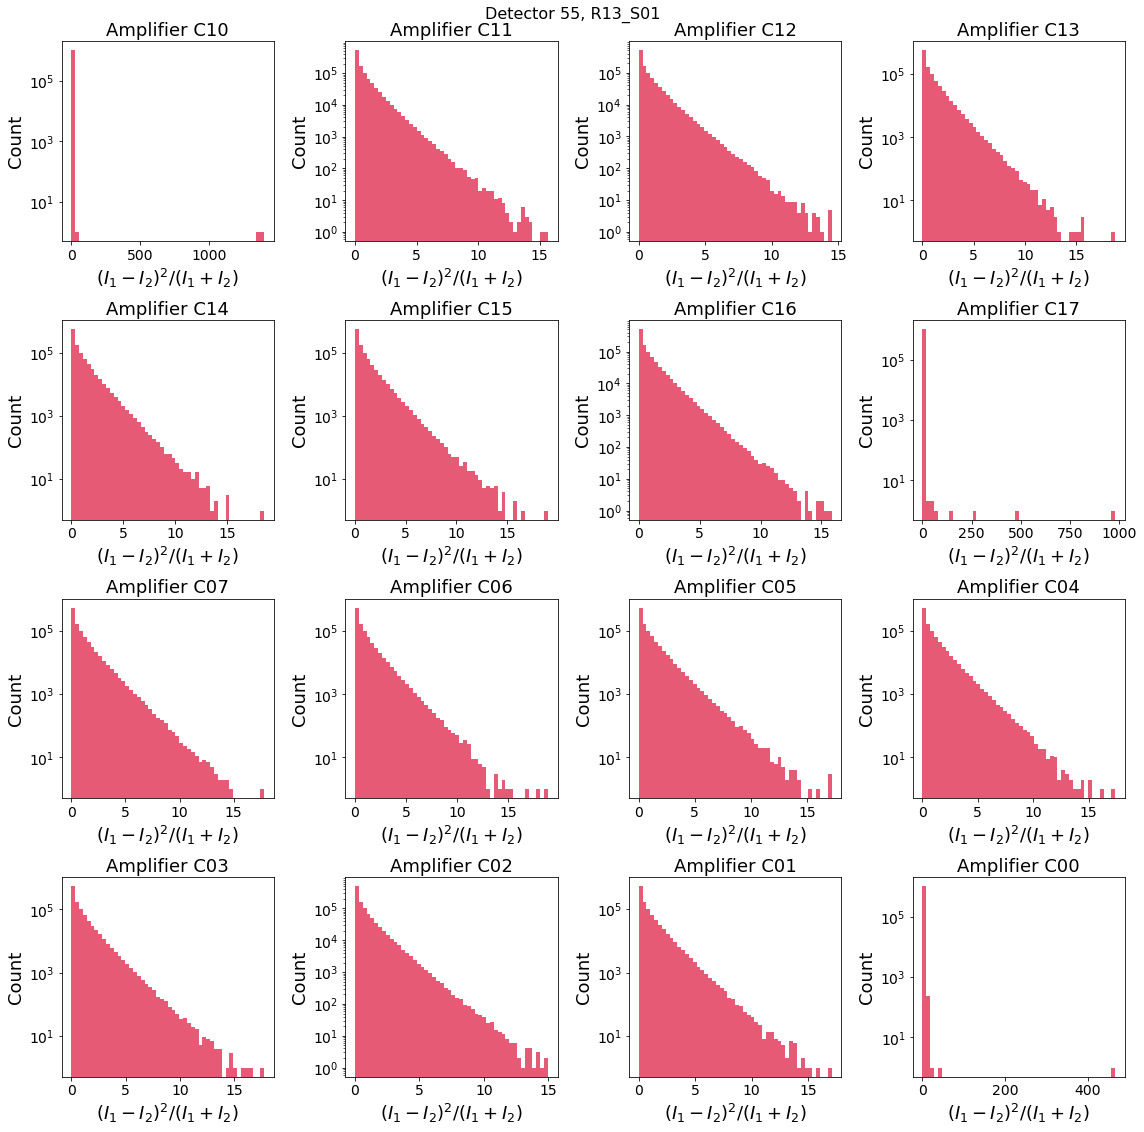

In [51]:
fig, axes = plt.subplots(4,4, figsize=(16,16))
fig.suptitle(f'Detector {CCD}, {det_id_to_name[CCD]}', fontsize=16)

count = 0  ##Count for amplifiers

for i in range(4):
    for j in range(4):
        region = amp_object[ampNames[count]]  ##Region of the amplifier
        im1Area = exp1.maskedImage[region]    ##Adding mask planes in the amplifier region
        im2Area = exp2.maskedImage[region]    

        im1AreaC = im1Area.clone()            ##Cloning image area
        im2AreaC = im2Area.clone()
        umask = np.logical_or(im1AreaC.mask.array, im2AreaC.mask.array)  ##Mask union of the two images

        im1_mask = np.ma.masked_where(umask, im1AreaC.image.array)  ##Applying mask to images
        im2_mask = np.ma.masked_where(umask, im2AreaC.image.array)


        diffIm = (im1_mask - im2_mask)**2
        sumIm = im1_mask + im2_mask
        ##The ratioIm is used to estimate the gain
        ratioIm = diffIm / sumIm
        
        ##Histogram of ratioIm
        axes[i,j].set_title(f'Amplifier {ampNames[count]}', fontsize=18)
        axes[i,j].hist(ratioIm.ravel(), bins=50, histtype='stepfilled', color = 'crimson', alpha=0.7)
        axes[i,j].set_yscale('log')
        axes[i,j].set_xlabel(f"$(I_1-I_2)^2 / (I_1+I_2)$", fontsize=18)
        axes[i,j].set_ylabel("Count", fontsize=18)
        axes[i,j].tick_params(labelsize=14)
        count +=1
fig.tight_layout()
fig.savefig(f'./FocalPlane_plots/Histogram_ratioIM_det{CCD}.png')

# Adding Brighter Effect

From https://github.com/craiglagegit/ScratchStuff/blob/master/reca/Two_Flats_05Aug22.ipynb , made by Professor Craig Lage.

# Implement a Toy BF effect

Basically moving charge from pixels with excess charge to adjacent pixels with less charge

In [52]:
def ApplyBF(array, BF_coef):
    (sizex, sizey) = array.shape                  ##Size of image
    for i in range(sizex-2):
        for j in range(sizey-2):
            delta1 = array[i,j] - array[i+1,j]    ##Variation of flux between adjacent pixels in the direction of the rows
            array[i, j] -= BF_coef * delta1**3    ##Remove flux from pixel "i"  and move to adjacent
            array[i+1, j] += BF_coef * delta1**3  ##Move the previous Flux to the adjacent pixel in rows
            delta2 = array[i,j] - array[i,j+1]    ##Variation of flux between adjacent pixels in the direction of the columns
            array[i, j] -= BF_coef * delta2**3    ##Remove flux from pixel "i" 
            array[i, j+1] += BF_coef * delta2**3  ##Move the previous Flux to the adjacent pixel in columns
    return array       

In [53]:
readNoise = 3.5
noBF_means = []
noBF_vars = []
gain_val = []

for level in [1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 100000]:
    f1 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f2 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f1Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f1 += f1Noise
    f1_mask = np.ma.masked_where(umask, f1) ##Applying mask to image 1
    f2Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f2 += f2Noise
    f2_mask = np.ma.masked_where(umask, f2) ##Applying mask to image 1
    
    var = np.mean((f1_mask - f2_mask) * (f1_mask - f2_mask)) / 2.0
    mean = np.mean(f1_mask + f2_mask) / 2.0
    noBF_vars.append(var)
    noBF_means.append(mean)
    
    const = np.mean((f1_mask - f2_mask) * (f1_mask - f2_mask) / (f1_mask + f2_mask))
    #const = np.mean((f1 - f2) * (f1 - f2) / (f1 + f2))
    
    mu = (np.mean(f1_mask) + np.mean(f2_mask)) / 2.0
    #mu = (np.mean(f1) + np.mean(f2)) / 2.0
    
    ## Full correction
    
    root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
    denom = (2*const*mu - 2*readNoise**2)
    positiveSolution = (root + mu)/denom
    gainLupton = positiveSolution
    gain_val += [gainLupton]

Text(0, 0.5, 'Variance [ADU]')

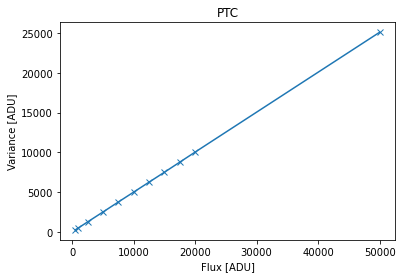

In [54]:
plt.plot(noBF_means, noBF_vars, marker = 'x')
plt.title('PTC')
plt.xlabel('Flux [ADU]')
plt.ylabel('Variance [ADU]')

Text(0, 0.5, 'Variance [ADU]')

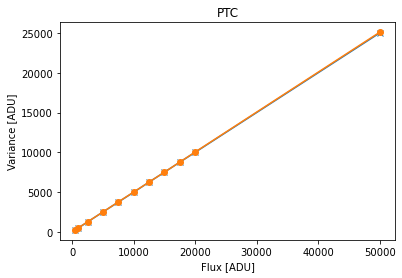

In [55]:
gain = 2.0  ## Expected Gain
noBF_means1 = []
noBF_vars1 = []
levels = np.arange(1000, 200000, 1000)

for level in [1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 100000]:  ##Flux
    f1 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f2 = np.random.poisson(level, size=(sizex, sizey)) / gain
    var = np.mean((f1 - f2) * (f1 - f2)) / 2.0
    mean = np.mean(f1 + f2) / 2.0
    noBF_vars1.append(var)
    noBF_means1.append(mean)


plt.plot(noBF_means1, noBF_vars1, marker = 'x')
plt.plot(noBF_means, noBF_vars, marker = 'o')
plt.title('PTC')
plt.xlabel('Flux [ADU]')
plt.ylabel('Variance [ADU]')

# Now repeat with BF

In [57]:
readNoise = 3.5
BF_coef = 1.0E-6
BF_means = []
BF_vars = []
gain_val = []
relative_error = []

for level in [1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000, 100000]:
    f1 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f2 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f1Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f1 += f1Noise
    f1_mask = np.ma.masked_where(umask, f1) ##Applying mask to image 1
    f1_mask = ApplyBF(f1_mask, BF_coef)
    f2Noise = np.random.normal(0.0, readNoise, size=(sizex, sizey))
    f2 += f2Noise
    f2_mask = np.ma.masked_where(umask, f2) ##Applying mask to image 2
    f2_mask = ApplyBF(f2_mask, BF_coef)
    
    var = np.mean((f1_mask - f2_mask) * (f1_mask - f2_mask)) / 2.0
    mean = np.mean(f1_mask + f2_mask) / 2.0
    noBF_vars.append(var)
    noBF_means.append(mean)
    
    const = np.mean((f1_mask - f2_mask) * (f1_mask - f2_mask) / (f1_mask + f2_mask))
    #const = np.mean((f1 - f2) * (f1 - f2) / (f1 + f2))
    
    mu = (np.mean(f1_mask) + np.mean(f2_mask)) / 2.0
    #mu = (np.mean(f1) + np.mean(f2)) / 2.0
    
    ## Full correction
    
    root = np.sqrt(mu**2 - 2*mu*const + 2*readNoise**2)
    denom = (2*const*mu - 2*readNoise**2)
    positiveSolution = (root + mu)/denom
    gainLupton = positiveSolution
    gain_val += [gainLupton]
    relative_error += [(gainLupton - gain) / gain * 100.0]
    
plt.plot(noBF_means, noBF_vars, marker = 'x', color='green', label="No BF") 
plt.plot(BF_means, BF_varss, marker = 'x', color='red', label=f"BF_coef={BF_coef:.2e}")
plt.title('PTC')
plt.xlabel('Flux [ADU]')
plt.ylabel('Variance [ADU]')
plt.legend(loc="upper left")

KeyboardInterrupt: 

In [ ]:
plt.plot(BF_means, relative_error, marker = 'x', color='red', label=f"BF_coef={BF_coef:.2e}")
plt.title('PTC')
plt.xlabel('Flux [ADU]')
plt.ylabel('Percent [%]')
plt.legend(loc="upper left")

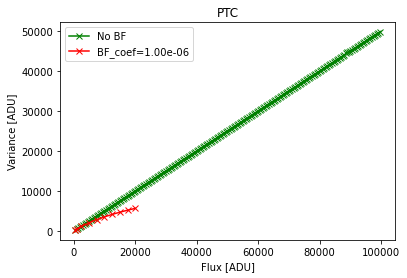

In [35]:
gain = 2.0
BF_coef = 1.0E-6
means = []
varss = []
gain_estimated = []
relative_error = []

for level in [1000, 2000, 5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000]:
    f1 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f1 = ApplyBF(f1, BF_coef)
    f2 = np.random.poisson(level, size=(sizex, sizey)) / gain
    f2 = ApplyBF(f2, BF_coef)
    var = np.mean((f1 - f2) * (f1 - f2)) / 2.0
    mean = np.mean(f1 + f2) / 2.0
    varss.append(var)
    means.append(mean)
    invGainLupton = np.mean((f1 - f2) * (f1 - f2) / (f1 + f2))
    gainLupton = 1.0 / invGainLupton
    relative_error += [(gainLupton - gain) / gain * 100.0]
    gain_estimated += [gainLupton] 
    
    #print(f"Flux={level}, Calculated gain={gainLupton:.3f}, Error={error:.2f}%")
plt.plot(noBF_means, noBF_vars, marker = 'x', color='green', label="No BF") 
plt.plot(means, varss, marker = 'x', color='red', label=f"BF_coef={BF_coef:.2e}")
plt.title('PTC')
plt.xlabel('Flux [ADU]')
plt.ylabel('Variance [ADU]')
plt.legend(loc="upper left")

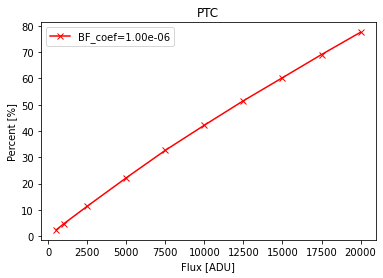

In [36]:
#plt.plot(noBF_means, noBF_vars, marker = 'x', color='green', label="No BF") 
plt.plot(means, relative_error, marker = 'x', color='red', label=f"BF_coef={BF_coef:.2e}")
plt.title('PTC')
plt.xlabel('Flux [ADU]')
plt.ylabel('Percent [%]')
plt.legend(loc="upper left")